# Greetings

The assessment does not indicate what metric are we looking out for, whether is it precision or recall that is important so I will take F1 as a metric.

My general approach is to see if the data is valid (missing, na) then inspect the data to extract some features that can be used for prediction.

Typically for classification there is a imbalanced data problem especially when one label is exceedingly rare (like fraud events). Normally my approach is to use SMOTE to over sample or I can also do under sampling or a combination of both to see the results on the dev set.

After iteration/ refinement of the models or features I will select models based on their final performance on the dev set. The final model will be used on the test set to return the score.

# Imports

In [1]:
import pandas as pd
import os
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import urllib.request
import zipfile
import warnings
import spacy
from langdetect import detect
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

SEED = 42
# Wider view
pd.set_option('max_colwidth', 1000)

# Read files

In [2]:
data_folder = 'data'
test_file = 'test.csv'
train_file = "train.csv"
val_file = "valid.csv"

test_path = os.path.join(data_folder, test_file)
train_path = os.path.join(data_folder, train_file)
val_path = os.path.join(data_folder, val_file)


In [3]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# EDA

In [4]:
# we have 4736 datapoints in train, 585 in val and 9 in test
train_df

,text,label
0,i m in solihull | do you want anything,1
1,gud mrng dear hav a nice day,1
2,dude how do you like the buff wind,1
3,yup wun believe wat u really neva c e msg i sent shuhui,1
4,did you get any gift this year i didnt get anything so bad,1
...,...,...
4731,hi wlcome back did wonder if you got eaten by a lion or something nothing much,1
4732,sorry i ll call later,1
4733,prabha i m soryda realy frm heart i m sory,1
4734,nt joking seriously i told,1


In [5]:
val_df

,text,label
0,hello darling how are you today i would love to have a chat why dont you tell me what you look like and what you are in to sexy,0
1,why did i wake up on my own gt,1
2,super msg da nalla timing,1
3,i want to be inside you every night,1
4,happy new year my no 1 man,1
...,...,...
580,you made my day do have a great day too,1
581,yeah sure thing mate haunt got all my stuff sorted but im going sound anyway promoting hex for by the way who is this dont know number joke,1
582,get me out of this dump heap my mom decided to come to lowes boring,1
583,ok i shall talk to him,1


In [6]:
# not inspecting test set to prevent data snooping
len(test_df)

9

In [7]:
test_df.shape

(9, 2)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4736 entries, 0 to 4735
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4736 non-null   object
 1   label   4736 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 74.1+ KB


In [9]:
# in the interest of time I assume no invalid, missing text. All labels have been checked i.e indicated spam means the message is really spam and same for true messages
train_df.isna().sum()

text     0
label    0
dtype: int64

## Check for duplicates

In [10]:
# we have 312 that are duplicates
train_df[train_df['text'].duplicated()]

,text,label
81,sorry i ll call later,1
125,sorry i ll call later,1
138,sorry i ll call later,1
268,arun can u transfr me d amt,1
317,final chance claim ur £150 worth of discount vouchers today text yes to 85023 now savamob member offers mobile t cs savamob pobox84 m263uz £3 00 subs 16,0
...,...,...
4701,you ve won tkts to the euro2004 cup final or £800 cash to collect call 09058099801 b4190604 pobox 7876150ppm,0
4713,what you doing how are you,1
4721,i cant pick the phone right now pls send a message,1
4732,sorry i ll call later,1


In [11]:
train_df = train_df.drop_duplicates()

## Check NA

In [12]:
train_df.isna().any()

text     False
label    False
dtype: bool

## Check for other languages

In [13]:
train_df['text'][0]

'i m in solihull  | do you want anything '

In [14]:
detect(train_df['text'][3])

'en'

In [15]:
try: 
    train_df['language'] = train_df['text'].apply(lambda x : detect(x)) 
except Exception as e:
    print(f'Unable to print due to error {e}')

Unable to print due to error No features in text.


In [16]:
# Empty text detected
language_list = []
for idx, text in enumerate(train_df['text']):
    try:
        language_list.append(detect(text))
    except:
        print(f"Error at idx : {idx} \n for text : {text} \n appending Error")
        language_list.append('Error')
else:
    print("Completed")

Error at idx : 1760 
 for text :         
 appending Error
Error at idx : 3885 
 for text :     
 appending Error
Completed


In [17]:
train_df['language'] = language_list

In [18]:
train_df['language'].value_counts()

en       3974
cy         51
af         47
no         41
so         39
nl         31
fr         29
da         23
ca         23
it         21
id         20
hr         18
sv         14
sw         12
sk         12
tl         10
pl         10
et          9
es          6
sq          5
ro          5
pt          5
tr          5
sl          5
de          4
cs          2
Error       2
fi          1
Name: language, dtype: int64

In [19]:
train_df[train_df['language']=='Error']

,text,label,language
1833,,1,Error
4123,,1,Error


In [20]:
# Czech
train_df[train_df['language']=='cs']

,text,label,language
963,no problem talk to you later,1,cs
3801,love you aathi love u lot,1,cs


In [21]:
# Slovenian
train_df[train_df['language']=='sl']

,text,label,language
162,ok no prob take ur time,1,sl
471,sindu got job in birla soft,1,sl
823,i m job profile seems like bpo,1,sl
3242,po de no need job aha,1,sl
3935,ok pa nothing problem,1,sl


In [22]:
# Apparently Singlish can be interpreted as many other languages
train_df[train_df['language']=='tl']

,text,label,language
10,also maaaan are you missing out,1,tl
92,yes mum lookin strong,1,tl
721,ay wana meet on sat ü wkg on sat,1,tl
1807,anything,1,tl
1816,oh kay on sat right,1,tl
1873,say thanks2,1,tl
1989,goodmorning sleeping ga,1,tl
2077,reading gud habit nan bari hudgi yorge pataistha ertini kano,1,tl
3174,k k advance happy pongal,1,tl
4031,ringtoneking 84484,0,tl


<AxesSubplot:ylabel='language'>

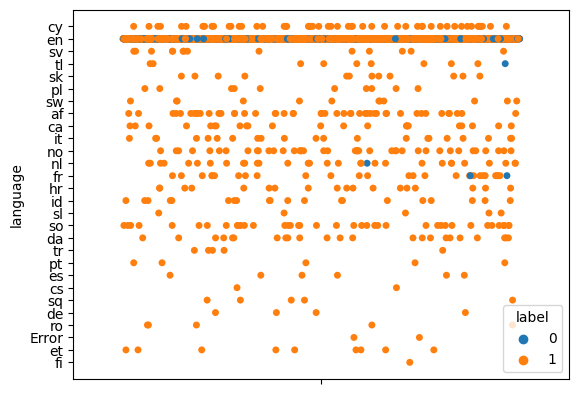

In [23]:
# Does not provide us much value since most are in en and the majority of text are categorised as english
sns.stripplot(data=train_df, y='language',jitter=0.4, hue='label')

## Remove Empty and add Length feature

In [24]:
train_df.drop(columns='language', inplace= True)

In [25]:
# remove trailing and leading spaces
train_df['length'] = train_df['text'].apply(lambda x : len(x.strip()))

In [26]:
train_df.iloc[1760]

text             
label           1
length          0
Name: 1833, dtype: object

In [27]:
train_df.iloc[3885]

text         
label       1
length      0
Name: 4123, dtype: object

In [28]:
empty_indicies = train_df[train_df['length']==0].index

In [29]:
train_df.drop(index=empty_indicies, inplace= True)

In [30]:
train_df

,text,label,length
0,i m in solihull | do you want anything,1,39
1,gud mrng dear hav a nice day,1,28
2,dude how do you like the buff wind,1,34
3,yup wun believe wat u really neva c e msg i sent shuhui,1,57
4,did you get any gift this year i didnt get anything so bad,1,60
...,...,...,...
4729,great princess i love giving and receiving oral doggy style is my fave position how about you i enjoy making love lt gt times per night,1,145
4730,lord of the rings return of the king in store now reply lotr by 2 june 4 chance 2 win lotr soundtrack cds stdtxtrate reply stop to end txts,0,140
4731,hi wlcome back did wonder if you got eaten by a lion or something nothing much,1,81
4734,nt joking seriously i told,1,26


In [31]:
len(train_df)

4422

<AxesSubplot:xlabel='label', ylabel='length'>

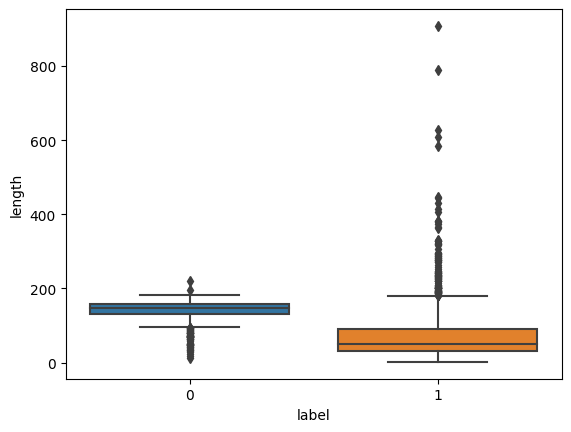

In [32]:
# I can consider this feature since spams (0) tend to be on average, longer than their counterparts
sns.boxplot(data = train_df, x='label', y= 'length')

## Explore Label

In [33]:
# not incredibly imbalanced (like 99% to 1%)
train_df['label'].value_counts(normalize=True)

1    0.870647
0    0.129353
Name: label, dtype: float64

In [34]:
train_df['label'].value_counts()

1    3850
0     572
Name: label, dtype: int64

In [35]:
val_df['label'].value_counts(normalize=True)

1    0.88547
0    0.11453
Name: label, dtype: float64

In [36]:
val_df['label'].value_counts()

1    518
0     67
Name: label, dtype: int64

In [37]:
# lets pick out 20 and see what we can observe to come out with some features
train_df[train_df['label']==1].sample(20, random_state=SEED)

,text,label,length
854,gd luck 4 ur exams,1,18
2817,he is a womdarfull actor,1,24
3284,they did t play one day last year know even though they have very good team like india,1,88
3698,ok that s great thanx a lot,1,27
2013,it could work we ll reach a consensus at the next meeting,1,58
1002,hey looks like i was wrong and one of the kappa guys numbers is still on my phone if you want i can text him and see if he s around,1,133
2626,no current and food here i am alone also,1,41
2337,heehee that was so funny tho,1,28
976,am also doing in cbe only but have to pay,1,42
4175,im just wondering what your doing right now,1,43


In [38]:
# lets pick out 20 and see what we can observe to come out with some features
train_df[train_df['label']==0].sample(20, random_state=SEED)

,text,label,length
4251,gent we are trying to contact you last weekends draw shows that you won a £1000 prize guaranteed call 09064012160 claim code k52 valid 12hrs only 150ppm,0,158
512,todays vodafone numbers ending with 4882 are selected to a receive a £350 award if your number matches call 09064019014 to receive your £350 award,0,147
964,thanks for your ringtone order ref number k718 your mobile will be charged £4 50 should your tone not arrive please call customer services on 09065069120,0,156
3260,would you like to see my xxx pics they are so hot they were nearly banned in the uk,0,83
4522,urgent your mobile number has been awarded with a £2000 bonus caller prize call 09058095201 from land line valid 12hrs only,0,126
2588,dorothy kiefer com bank of granite issues strong buy explosive pick for our members up over 300 nasdaq symbol cdgt that is a 5 00 per,0,154
1498,we have new local dates in your area lots of new people registered in your area reply date to start now 18 only www flirtparty us replys150,0,143
205,ur hmv quiz cash balance is currently £500 to maximize ur cash in now send hmv1 to 86688 only 150p/msg,0,104
582,free entry to the gr8prizes wkly comp 4 a chance to win the latest nokia 8800 psp or £250 cash every wk txt great to 80878 http//www gr8prizes com 08715705022,0,159
2498,ur cash balance is currently 500 pounds to maximize ur cash in now send go to 86688 only 150p/msg cc 08718720201 po box 114/14 tcr/w1,0,137


In [39]:
# We can use some visualisation
train_df_scam = train_df[train_df['label']==0]
train_df_gen = train_df[train_df['label']!=0]
scam_corpus = ''.join(word for word in train_df_scam.text)
gen_corpus = ''.join(word for word in train_df_gen.text)

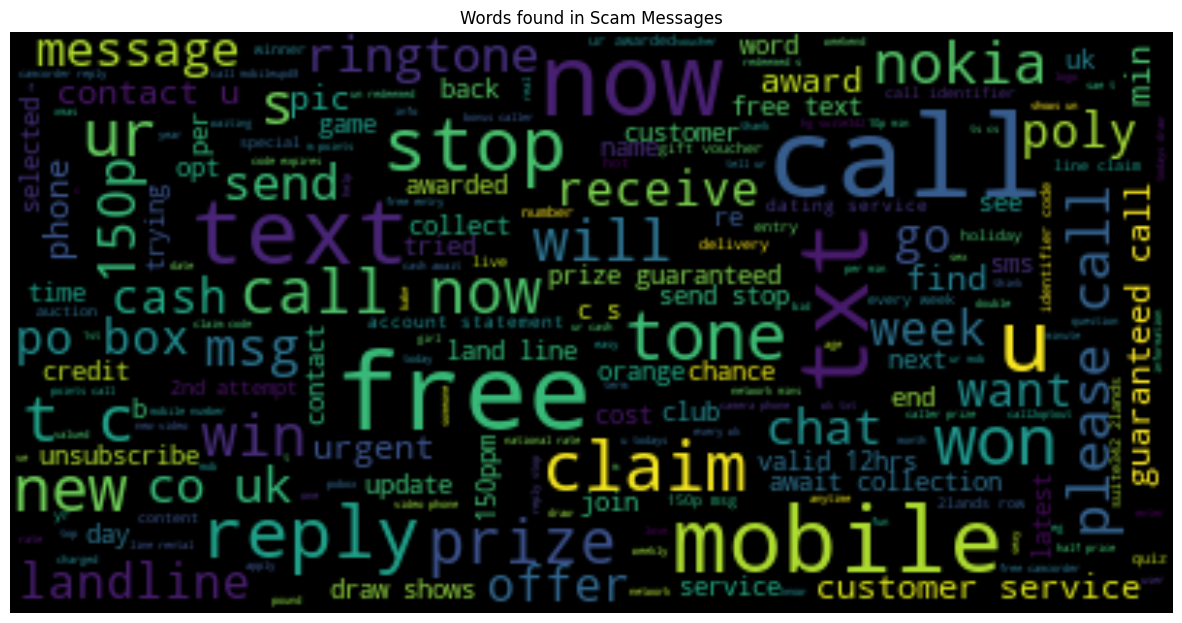

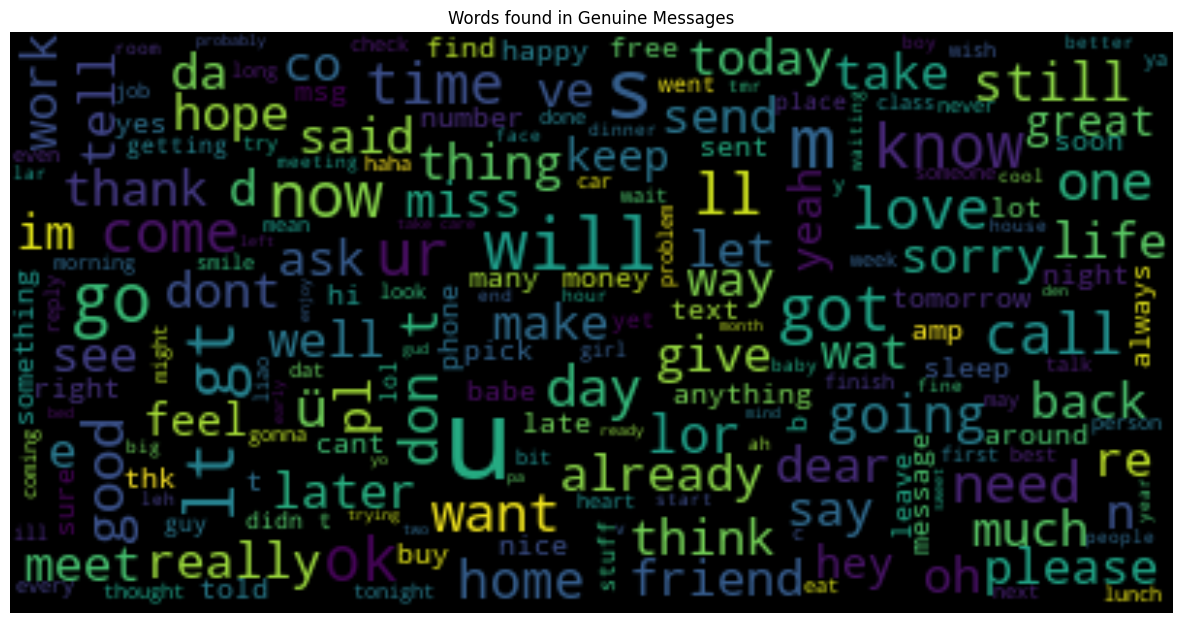

In [40]:
# code taken from wordcloud tutorial
# Generate a word cloud image
wordcloud_scam = WordCloud(max_font_size=40).generate(scam_corpus)
wordcloud_gen = WordCloud(max_font_size=40).generate(gen_corpus)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.imshow(wordcloud_scam, interpolation='bilinear')
plt.title("Words found in Scam Messages")
plt.axis("off")

# lower max_font_size
plt.figure(figsize=(15,15))
plt.title("Words found in Genuine Messages")
plt.imshow(wordcloud_gen, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

Some scam signs are possibly:
- containing words like
  - call
  - txt
  - now
  - won
  - free
- some $ or phone number or some prize money. I see money also is used in some genuine text
- perhaps length? I see(read) somewhere length is a predictor
- I dont see captialisation being a feature
- If time permits can check readability index (flesch)

# Feature Engineering

## Words

- Try words like
  - money
  - prize
  - win
  - reward
  - winner
  - lucky

In [41]:
train_df_scamy= train_df[train_df['text'].str.contains('money') | \
    train_df['text'].str.contains('prize') | \
    train_df['text'].str.contains('win') | \
    train_df['text'].str.contains('prize') | \
    train_df['text'].str.contains('win') | \
    train_df['text'].str.contains('reward') | \
    train_df['text'].str.contains('winner')| \
    train_df['text'].str.contains('lucky')]

In [42]:
# I noticed in the examples especially the first one it is caught because 'win' is a substring of 'wind' 
# If possible I will catch only whole words 
train_df_scamy

,text,label,length
2,dude how do you like the buff wind,1,34
35,i can t describe how lucky you are that i m actually awake by noon,1,66
46,important information 4 orange user 0789xxxxxxx today is your lucky day 2find out why log onto http //www urawinner com there s a fantastic surprise awaiting you,0,162
70,123 congratulations in this week s competition draw u have won the £1450 prize to claim just call 09050002311 b4280703 t cs/stop sms 08718727868 over 18 only 150ppm,0,168
71,urgent your mobile number won a £2000 bonus caller prize on 10/06/03 this is the 2nd attempt to reach you call 09066368753 asap box 97n7qp 150ppm,0,166
...,...,...,...
4653,cool so how come you havent been wined and dined before,1,56
4679,freemsg you have been awarded a free mini digital camera just reply snap to collect your prize quizclub opt out stop 80122300p/wk sp rwm ph 08704050406,0,155
4690,uncle boye i need movies oh guide me plus you know torrents are not particularly legal here and the system is slowing down what should i do have a gr8 day plus have you started cos i dont meet you online how was the honey moon,1,234
4718,k k i m going to tirunelvali this week to see my uncle i already spend the amount by taking dress so only i want money i will give it on feb 1,1,146


In [43]:
train_df_scamy['label'].value_counts(normalize=True)

0    0.570175
1    0.429825
Name: label, dtype: float64

In [44]:
# We have 640 scam texts and the feature got 146 which aint bad but has false positives coz it caught some negatives.
# hopefully this feature when combined with others turns out to be good
train_df_scamy['label'].value_counts()

0    130
1     98
Name: label, dtype: int64

In [45]:
train_df_scamy= train_df[train_df['text'].str.contains('call') | \
    train_df['text'].str.contains('text') | \
    train_df['text'].str.contains('won') | \
    train_df['text'].str.contains('free')]

In [46]:
# I noticed in the examples especially the first one it is caught because 'win' is a substring of 'wind' 
# If possible I will catch only whole words 
train_df_scamy

,text,label,length
5,hello from orange for 1 month s free access to games news and sport plus 10 free texts and 20 photo messages reply yes terms apply www orange co uk/ow,0,156
14,well balls time to make calls,1,31
29,sir hope your day is going smoothly i really hoped i wont have to bother you about this i have some bills that i can t settle this month i am out of all extra cash i know this is a challenging time for you also but i have to let you know,1,242
44,you ve won tkts to the euro2004 cup final or £800 cash to collect call 09058099801 b4190604 pobox 7876150ppm,0,110
48,hey boys want hot xxx pics sent direct 2 ur phone txt porn to 69855 24hrs free and then just 50p per day to stop text stopbcm sf wc1n3xx,0,140
...,...,...,...
4694,unlimited texts limited minutes,1,32
4695,from next month get upto 50 more calls 4 ur standard network charge 2 activate call 9061100010 c wire3 net 1st4terms pobox84 m26 3uz cost £1 50 min mobcudb more,0,161
4700,private your 2003 account statement for shows 800 un redeemed s i m points call 08718738002 identifier code 48922 expires 21/11/04,0,136
4714,free msg we billed your mobile number by mistake from shortcode 83332 please call 08081263000 to have charges refunded this call will be free from a bt landline,0,160


In [47]:
train_df_scamy['label'].value_counts(normalize=True)

0    0.521127
1    0.478873
Name: label, dtype: float64

In [48]:
# We have 640 scam texts and the feature got 146 which aint bad but has false positives coz it caught some negatives.
# hopefully this feature when combined with others turns out to be good
train_df_scamy['label'].value_counts()

0    407
1    374
Name: label, dtype: int64

In [49]:
train_df_scamy= train_df[train_df['text'].str.contains('money') | \
    train_df['text'].str.contains('prize') | \
    train_df['text'].str.contains('win') | \
    train_df['text'].str.contains('prize') | \
    train_df['text'].str.contains('win') | \
    train_df['text'].str.contains('reward') | \
    train_df['text'].str.contains('winner')| \
    train_df['text'].str.contains('lucky') | \
    train_df['text'].str.contains('call') | \
    train_df['text'].str.contains('text') | \
    train_df['text'].str.contains('won') | \
    train_df['text'].str.contains('free')]

In [50]:
train_df_scamy['label'].value_counts(normalize=True)

1    0.504405
0    0.495595
Name: label, dtype: float64

In [51]:
# The smaller list have a higher recall and increasing the number of words provide only marginal benefits
train_df_scamy['label'].value_counts()

1    458
0    450
Name: label, dtype: int64

In [52]:
scamy_words = ['call','text','won','now','free']

In [53]:
train_df['scamy_words']= train_df['text'].apply(lambda x: any([k in x for k in scamy_words]))

In [54]:
train_df['scamy_words'] = train_df['scamy_words'].astype('int')

In [55]:
train_df

,text,label,length,scamy_words
0,i m in solihull | do you want anything,1,39,0
1,gud mrng dear hav a nice day,1,28,0
2,dude how do you like the buff wind,1,34,0
3,yup wun believe wat u really neva c e msg i sent shuhui,1,57,0
4,did you get any gift this year i didnt get anything so bad,1,60,0
...,...,...,...,...
4729,great princess i love giving and receiving oral doggy style is my fave position how about you i enjoy making love lt gt times per night,1,145,0
4730,lord of the rings return of the king in store now reply lotr by 2 june 4 chance 2 win lotr soundtrack cds stdtxtrate reply stop to end txts,0,140,1
4731,hi wlcome back did wonder if you got eaten by a lion or something nothing much,1,81,1
4734,nt joking seriously i told,1,26,0


<AxesSubplot:>

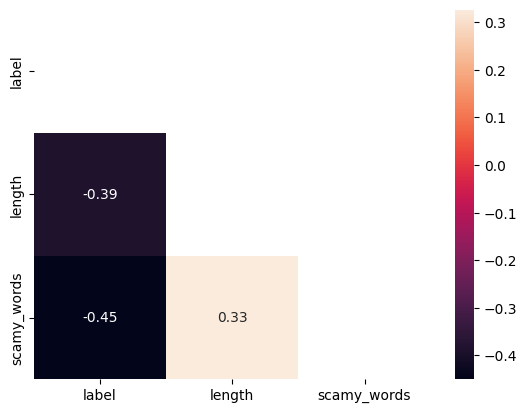

In [56]:
mask = np.triu(train_df.corr())
sns.heatmap(train_df.corr(), annot=True, fmt=".2f", mask= mask)

## Numbers

In [57]:
train_df['numbers']= train_df['text'].str.extract(r"(\d+)")

In [58]:
train_df[train_df.numbers.isna() == False]['numbers'] = 1

In [59]:
train_df.numbers.fillna(0, inplace=True)

In [60]:
train_df['numbers'] = train_df['numbers'].apply(lambda x: 1 if x !=0 else 0)

In [61]:
train_df

,text,label,length,scamy_words,numbers
0,i m in solihull | do you want anything,1,39,0,0
1,gud mrng dear hav a nice day,1,28,0,0
2,dude how do you like the buff wind,1,34,0,0
3,yup wun believe wat u really neva c e msg i sent shuhui,1,57,0,0
4,did you get any gift this year i didnt get anything so bad,1,60,0,0
...,...,...,...,...,...
4729,great princess i love giving and receiving oral doggy style is my fave position how about you i enjoy making love lt gt times per night,1,145,0,0
4730,lord of the rings return of the king in store now reply lotr by 2 june 4 chance 2 win lotr soundtrack cds stdtxtrate reply stop to end txts,0,140,1,1
4731,hi wlcome back did wonder if you got eaten by a lion or something nothing much,1,81,1,0
4734,nt joking seriously i told,1,26,0,0


In [62]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4422 entries, 0 to 4735
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         4422 non-null   object
 1   label        4422 non-null   int64 
 2   length       4422 non-null   int64 
 3   scamy_words  4422 non-null   int32 
 4   numbers      4422 non-null   int64 
dtypes: int32(1), int64(3), object(1)
memory usage: 319.0+ KB


<AxesSubplot:>

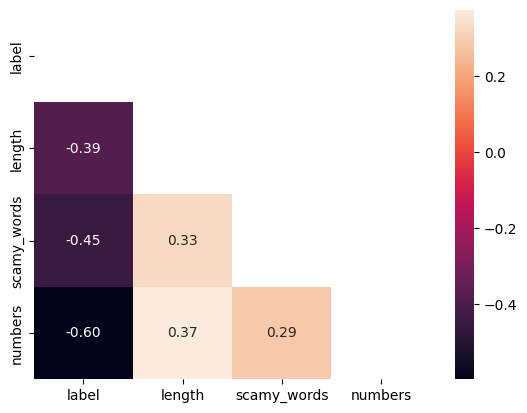

In [63]:
mask = np.triu(train_df.corr())
sns.heatmap(train_df.corr(), annot=True, fmt=".2f", mask= mask)

## Text itself

### Count Vectorizer

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

In [65]:
bow = CountVectorizer()
bow.fit(train_df['text'])
countvec_X = bow.transform(train_df['text'])

In [66]:
countvec_X_df = pd.DataFrame(countvec_X.toarray(), columns=sorted(bow.vocabulary_))
countvec_X_df


,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TFIDF Vectorizer

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [68]:
tfidf = TfidfVectorizer()

In [69]:
tfidf.fit(train_df['text'])

TfidfVectorizer()

In [70]:
tfidf_x = tfidf.transform(train_df['text'])

In [71]:
type(tfidf.vocabulary_)

dict

In [72]:
list(tfidf.vocabulary_.keys())

['in',
 'solihull',
 'do',
 'you',
 'want',
 'anything',
 'gud',
 'mrng',
 'dear',
 'hav',
 'nice',
 'day',
 'dude',
 'how',
 'like',
 'the',
 'buff',
 'wind',
 'yup',
 'wun',
 'believe',
 'wat',
 'really',
 'neva',
 'msg',
 'sent',
 'shuhui',
 'did',
 'get',
 'any',
 'gift',
 'this',
 'year',
 'didnt',
 'so',
 'bad',
 'hello',
 'from',
 'orange',
 'for',
 'month',
 'free',
 'access',
 'to',
 'games',
 'news',
 'and',
 'sport',
 'plus',
 '10',
 'texts',
 '20',
 'photo',
 'messages',
 'reply',
 'yes',
 'terms',
 'apply',
 'www',
 'co',
 'uk',
 'ow',
 'still',
 'attending',
 'da',
 'talks',
 'thk',
 'some',
 'of',
 'em',
 'find',
 'wtc',
 'too',
 'far',
 'weiyi',
 'not',
 'goin',
 'rest',
 'dunno',
 'yet',
 'ur',
 'dinner',
 'den',
 'might',
 'able',
 'join',
 'oh',
 'is',
 'it',
 'send',
 'me',
 'address',
 'my',
 'sister',
 'law',
 'hope',
 'are',
 'having',
 'great',
 'just',
 'saying',
 'hey',
 'abiola',
 'also',
 'maaaan',
 'missing',
 'out',
 'nope',
 'market',
 'coming',
 'back',


In [73]:
tfidf_pd = pd.DataFrame(tfidf_x.todense())

In [74]:
tfidf_pd.columns = tfidf.vocabulary_.keys()

In [75]:
tfidf_pd

,in,solihull,do,you,want,anything,gud,mrng,dear,hav,...,jam,hannaford,wheat,chex,oral,lord,rings,soundtrack,stdtxtrate,wlcome
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

In [76]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Metrics
from sklearn.metrics import classification_report, roc_auc_score

## Preprocessing

Steps include
- Remove Dup
- Remove NA
- Add Length feature
- Add Numbers feature
- Add Scamy_word feature
- Add CountVector Feature
- Remove Text

In [77]:
train_df.head()

,text,label,length,scamy_words,numbers
0,i m in solihull | do you want anything,1,39,0,0
1,gud mrng dear hav a nice day,1,28,0,0
2,dude how do you like the buff wind,1,34,0,0
3,yup wun believe wat u really neva c e msg i sent shuhui,1,57,0,0
4,did you get any gift this year i didnt get anything so bad,1,60,0,0


In [78]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from src.datapipeline import transform

In [79]:
train_df_val = pd.read_csv(train_path)
val_df_val = pd.read_csv(val_path)
test_df_val = pd.read_csv(test_path)

In [80]:
len(train_df_val)

4736

In [81]:
# remove trailing and leading spaces
train_df_val['length'] = train_df_val['text'].apply(lambda x : len(x.strip()))

In [82]:
train_df_val.iloc[1760]

text      big brother‘s really scraped the barrel with this shower of social misfits
label                                                                              1
length                                                                            74
Name: 1760, dtype: object

In [83]:
train_df_val.iloc[3885]

text      oh  as usual vijay film or its different 
label                                             1
length                                           40
Name: 3885, dtype: object

In [84]:
train_df_val[train_df_val.length ==0 ]

,text,label,length
1833,,1,0
4123,,1,0


In [85]:
scamy_words

['call', 'text', 'won', 'now', 'free']

In [86]:
train_df_val = transform(train_df_val, scamy_words)

In [87]:
train_df_val

,text,label,length,scamy_words,numbers
0,i m in solihull | do you want anything,1,39,0,0
1,gud mrng dear hav a nice day,1,28,0,0
2,dude how do you like the buff wind,1,34,0,0
3,yup wun believe wat u really neva c e msg i sent shuhui,1,57,0,0
4,did you get any gift this year i didnt get anything so bad,1,60,0,0
...,...,...,...,...,...
4729,great princess i love giving and receiving oral doggy style is my fave position how about you i enjoy making love lt gt times per night,1,145,0,0
4730,lord of the rings return of the king in store now reply lotr by 2 june 4 chance 2 win lotr soundtrack cds stdtxtrate reply stop to end txts,0,140,1,1
4731,hi wlcome back did wonder if you got eaten by a lion or something nothing much,1,81,1,0
4734,nt joking seriously i told,1,26,0,0


In [88]:
train_df_val[train_df_val.length==0]

,text,label,length,scamy_words,numbers


In [89]:
len(train_df_val)

4422

In [90]:
len(train_df)

4422

In [91]:
assert train_df_val.equals(train_df)

In [92]:
y_train = train_df.pop('label')

In [93]:
train_df.drop(columns='text', inplace=True)

In [94]:
train_df.values

array([[39,  0,  0],
       [28,  0,  0],
       [34,  0,  0],
       ...,
       [81,  1,  0],
       [26,  0,  0],
       [39,  0,  0]], dtype=int64)

In [95]:
countvec_X.toarray().shape

(4422, 7952)

In [96]:
np.concatenate([countvec_X.toarray(),train_df.values], axis=1)

array([[ 0,  0,  0, ..., 39,  0,  0],
       [ 0,  0,  0, ..., 28,  0,  0],
       [ 0,  0,  0, ..., 34,  0,  0],
       ...,
       [ 0,  0,  0, ..., 81,  1,  0],
       [ 0,  0,  0, ..., 26,  0,  0],
       [ 0,  0,  0, ..., 39,  0,  0]], dtype=int64)

In [97]:
from src.datapipeline import Datapipeline

In [98]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [99]:
pipe = Datapipeline(train_df, val_df, test_df)

In [100]:
train_df

,text,label
0,i m in solihull | do you want anything,1
1,gud mrng dear hav a nice day,1
2,dude how do you like the buff wind,1
3,yup wun believe wat u really neva c e msg i sent shuhui,1
4,did you get any gift this year i didnt get anything so bad,1
...,...,...
4731,hi wlcome back did wonder if you got eaten by a lion or something nothing much,1
4732,sorry i ll call later,1
4733,prabha i m soryda realy frm heart i m sory,1
4734,nt joking seriously i told,1


In [101]:
val_df

,text,label
0,hello darling how are you today i would love to have a chat why dont you tell me what you look like and what you are in to sexy,0
1,why did i wake up on my own gt,1
2,super msg da nalla timing,1
3,i want to be inside you every night,1
4,happy new year my no 1 man,1
...,...,...
580,you made my day do have a great day too,1
581,yeah sure thing mate haunt got all my stuff sorted but im going sound anyway promoting hex for by the way who is this dont know number joke,1
582,get me out of this dump heap my mom decided to come to lowes boring,1
583,ok i shall talk to him,1


In [102]:
X_train, y_train = pipe.transform(train_df)
X_val, y_val = pipe.transform(val_df)
X_test, y_test = pipe.transform(test_df)

In [103]:
print(f"Train: X shape {X_train.shape} and y shape {y_train.shape}")
print(f"Val: X shape {X_val.shape} and y shape {y_val.shape}")
print(f"Test: X shape {X_test.shape} and y shape {y_test.shape}")

Train: X shape (4422, 7955) and y shape (4422,)
Val: X shape (580, 7955) and y shape (580,)
Test: X shape (9, 7955) and y shape (9,)


## Shortlisting

### Countvectoriser

In [104]:
rfc = RandomForestClassifier(random_state=SEED)
svc = SVC(random_state=SEED)
knn = KNeighborsClassifier()
logreg = LogisticRegression()

In [105]:
classifiers = [rfc, svc, knn, logreg]

In [106]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    print(f'Classifier is {clf}')
    print(classification_report(y_val,y_val_pred))

Classifier is RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

           0       1.00      0.86      0.93        66
           1       0.98      1.00      0.99       514

    accuracy                           0.98       580
   macro avg       0.99      0.93      0.96       580
weighted avg       0.98      0.98      0.98       580

Classifier is SVC(random_state=42)
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        66
           1       0.99      1.00      0.99       514

    accuracy                           0.98       580
   macro avg       0.98      0.95      0.96       580
weighted avg       0.98      0.98      0.98       580

Classifier is KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.97      0.50      0.66        66
           1       0.94      1.00      0.97       514

    accuracy                           0.94       580
  

### tfidf vectoriser

In [107]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [108]:
pipe = Datapipeline(train_df, val_df, test_df, countVec=False, tfidf=True)

In [109]:
X_train, y_train = pipe.transform(train_df)
X_val, y_val = pipe.transform(val_df)
X_test, y_test = pipe.transform(test_df)

In [110]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    print(f'Classifier is {clf}')
    print(classification_report(y_val,y_val_pred))

Classifier is RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        66
           1       0.98      1.00      0.99       514

    accuracy                           0.98       580
   macro avg       0.99      0.92      0.95       580
weighted avg       0.98      0.98      0.98       580

Classifier is SVC(random_state=42)
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        66
           1       0.98      1.00      0.99       514

    accuracy                           0.98       580
   macro avg       0.99      0.92      0.95       580
weighted avg       0.98      0.98      0.98       580

Classifier is KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.93      0.86      0.90        66
           1       0.98      0.99      0.99       514

    accuracy                           0.98       580
  

In [111]:
len(tfidf.get_feature_names_out())

7952

In [112]:
len(tfidf.idf_)

7952

In [113]:
tfidf_values = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

In [114]:
dict(sorted(tfidf_values.items(), key=lambda item: item[1]))

{'to': 2.1830167445545254,
 'you': 2.2152655083642925,
 'the': 2.7000114193472315,
 'and': 2.914528915941674,
 'in': 2.922227183367426,
 'is': 3.0506930437419957,
 'me': 3.0630716279746357,
 'for': 3.1940643038256367,
 'it': 3.2042580720151794,
 'my': 3.2228728804574116,
 'your': 3.250387843742681,
 'of': 3.34248430894391,
 'have': 3.3519406441859454,
 'that': 3.3638882176070632,
 'call': 3.3931585999071765,
 'on': 3.4413301435805423,
 'now': 3.4810704722300567,
 'are': 3.4864905396993957,
 'can': 3.5196427470162965,
 'so': 3.5309423022702298,
 'not': 3.5481347028106023,
 'but': 3.5539318204949284,
 'or': 3.629382375083482,
 'at': 3.674261701260915,
 'be': 3.6907910032121256,
 'get': 3.6941299044776406,
 'do': 3.7075981215285068,
 'just': 3.7075981215285068,
 'we': 3.7281467897558946,
 'will': 3.7350912621087056,
 'with': 3.7851016826833668,
 'no': 3.796151518869952,
 'if': 3.80358649735747,
 'this': 3.82622897410723,
 'how': 3.8533099327099007,
 'up': 3.85723921084979,
 'ur': 3.934987

In [115]:
dict(sorted(tfidf_values.items(), key=lambda item: item[1], reverse=True))

{'000pes': 8.70142629730838,
 '0089': 8.70142629730838,
 '0121': 8.70142629730838,
 '01223585236': 8.70142629730838,
 '01223585334': 8.70142629730838,
 '0125698789': 8.70142629730838,
 '02072069400': 8.70142629730838,
 '02085076972': 8.70142629730838,
 '021': 8.70142629730838,
 '0430': 8.70142629730838,
 '07008009200': 8.70142629730838,
 '07046744435': 8.70142629730838,
 '07090298926': 8.70142629730838,
 '07099833605': 8.70142629730838,
 '0721072': 8.70142629730838,
 '07732584351': 8.70142629730838,
 '07734396839': 8.70142629730838,
 '07742676969': 8.70142629730838,
 '07753741225': 8.70142629730838,
 '07781482378': 8.70142629730838,
 '07786200117': 8.70142629730838,
 '077xxx': 8.70142629730838,
 '078': 8.70142629730838,
 '07801543489': 8.70142629730838,
 '07808': 8.70142629730838,
 '07808247860': 8.70142629730838,
 '07808726822': 8.70142629730838,
 '07815296484': 8.70142629730838,
 '07821230901': 8.70142629730838,
 '07880867867': 8.70142629730838,
 '0789xxxxxxx': 8.70142629730838,
 '07

# Second Iteration

## Feature Importance

In [116]:
list(train_df_val.columns).remove('text')

In [117]:
original_col_names = list(train_df_val.columns)

In [118]:
original_col_names.remove('text')

In [119]:
original_col_names.remove('label')

In [120]:
col_names = list(tfidf.get_feature_names_out()) + original_col_names

In [121]:
assert len(rfc.feature_importances_) == len(col_names)

<AxesSubplot:title={'center':'Feature Importance (Random Forest)'}, ylabel='Importance'>

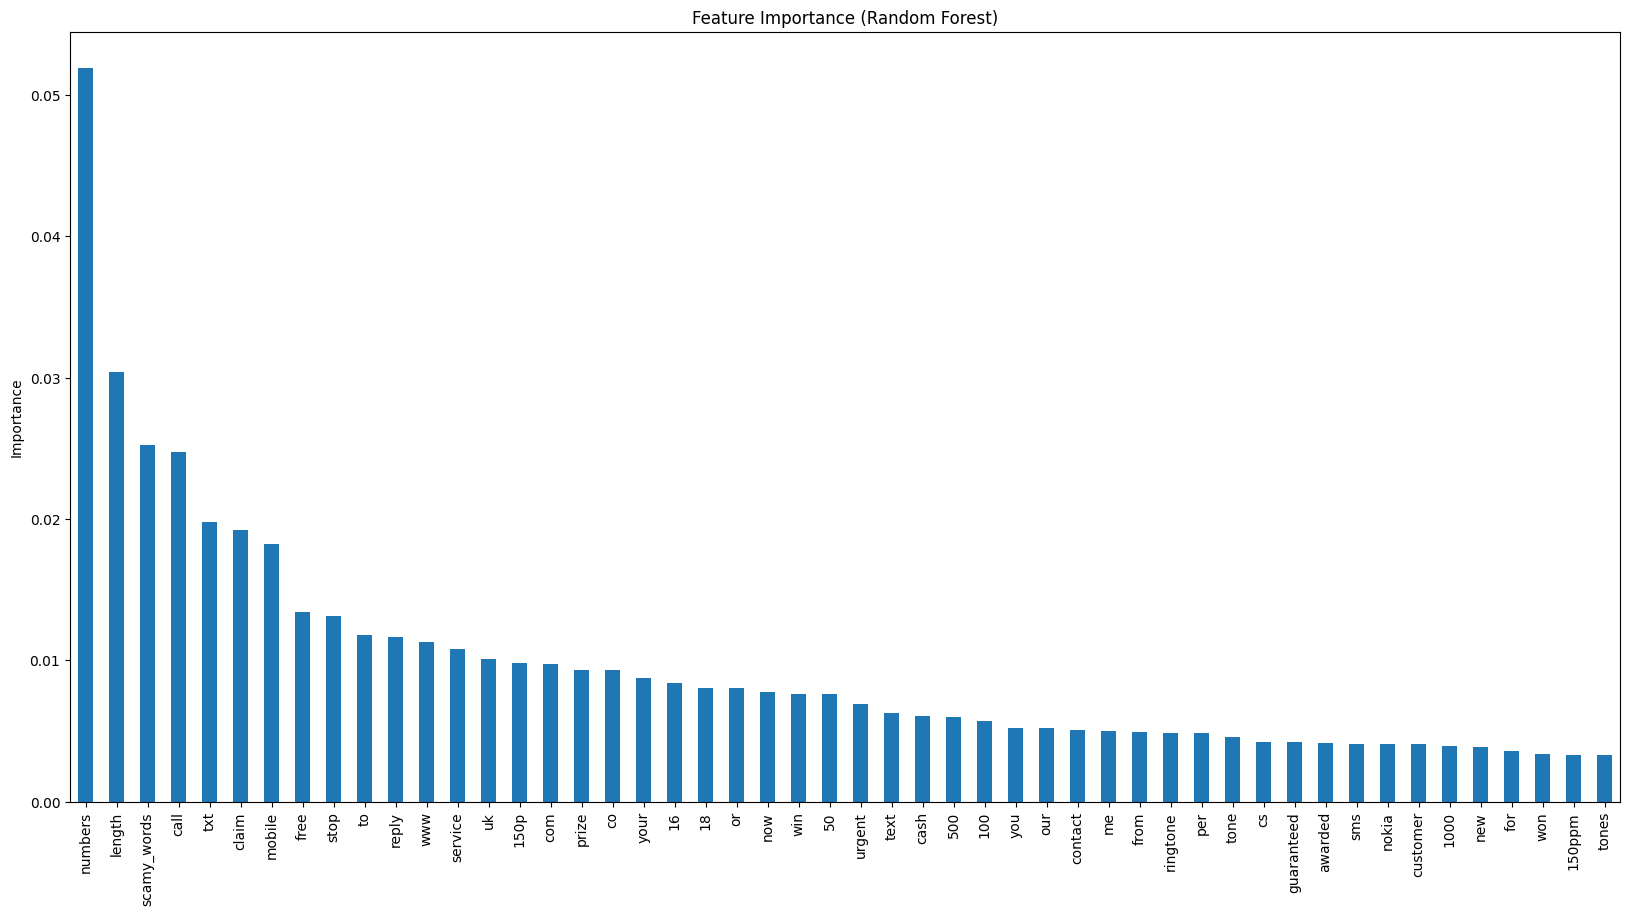

In [122]:
important_features = pd.Series(data=rfc.feature_importances_, index=col_names)
important_features.sort_values(ascending=False, inplace=True)
important_features[:50].plot(kind="bar", title = 'Feature Importance (Random Forest)', ylabel = 'Importance', figsize=(20,10))

In [123]:
scamy_words

['call', 'text', 'won', 'now', 'free']

In [124]:
# Revise scamy words
scamy_words = ['call', 'text', 'won', 'mobile', 'free']

In [125]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [126]:
pipe = Datapipeline(train_df, val_df, test_df, scamy_words=scamy_words)

In [127]:
X_train, y_train = pipe.transform(train_df)
X_val, y_val = pipe.transform(val_df)
X_test, y_test = pipe.transform(test_df)

In [128]:
print(f"Train: X shape {X_train.shape} and y shape {y_train.shape}")
print(f"Val: X shape {X_val.shape} and y shape {y_val.shape}")
print(f"Test: X shape {X_test.shape} and y shape {y_test.shape}")

Train: X shape (4422, 7955) and y shape (4422,)
Val: X shape (580, 7955) and y shape (580,)
Test: X shape (9, 7955) and y shape (9,)


In [129]:
rfc = RandomForestClassifier(random_state=SEED)
svc = SVC(random_state=SEED)

In [130]:
classifiers = [rfc, svc]

In [131]:
from sklearn.model_selection import GridSearchCV

In [132]:
params_rfc = {'n_estimators': range(50,250,50),
             'random_state': [SEED]}
params_svc = {'random_state': [SEED],
              'C': [1, 10, 100, 1000],
              'gamma': [0.001, 0.0001]}

params = {
    rfc: params_rfc,
    svc: params_svc
    }

In [133]:
for model, params in params.items():
    cv = GridSearchCV(model,params,cv=5)
    cv.fit(X_train, y_train)
    y_val_pred = cv.predict(X_val)
    print(f'Classifier is {model}')
    print(f"best params are {cv.best_params_}")
    print(classification_report(y_val,y_val_pred))

Classifier is RandomForestClassifier(random_state=42)
best params are {'n_estimators': 200, 'random_state': 42}
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        66
           1       0.98      1.00      0.99       514

    accuracy                           0.98       580
   macro avg       0.99      0.92      0.95       580
weighted avg       0.98      0.98      0.98       580

Classifier is SVC(random_state=42)
best params are {'C': 1000, 'gamma': 0.001, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.95      0.89      0.92        66
           1       0.99      0.99      0.99       514

    accuracy                           0.98       580
   macro avg       0.97      0.94      0.96       580
weighted avg       0.98      0.98      0.98       580



In [136]:
svc = SVC(C=1000,gamma=0.001,random_state=SEED)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.62      1.00      0.77         5

    accuracy                           0.67         9
   macro avg       0.81      0.62      0.58         9
weighted avg       0.79      0.67      0.61         9



## Embeddings

## Using Glove

In [137]:
# check if data contains glove embeddings else download

glove_embeddings_zip_path = 'data/glove.6B.zip'

if os.path.exists(glove_embeddings_zip_path):
    pass
else:
    urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip',glove_embeddings_zip_path)


In [138]:
# Check if glove has been unzip, else unzip it
zip_path = 'data/glove'

if os.path.exists(zip_path):
    pass
else:
    with zipfile.ZipFile(glove_embeddings_zip_path, 'r') as zip_ref:
        zip_ref.extractall(zip_path)

In [139]:
embeddings_dict = {}
with open("data/glove/glove.6B.50d.txt", 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [140]:
train_df.text[0]

'i m in solihull  | do you want anything '

In [141]:
import spacy 
nlp = spacy.load("en_core_web_sm")

In [142]:
token_text = [nlp(token) for token in train_df['text']]

## Using doc2vec

In [143]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim

In [144]:
def preprocess_df_into_tagdoc(df, tokens_only=False, series:bool = False):
    if series == False:
        for idx, line in enumerate(df['text']):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [idx])
    else:
        for idx, line in enumerate(df):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [idx])

In [145]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [146]:
y_train = train_df.pop('label')
y_val = val_df.pop('label')

In [147]:
train_corpus = list(preprocess_df_into_tagdoc(train_df))
val_corpus = list(preprocess_df_into_tagdoc(val_df))
test_corpus = list(preprocess_df_into_tagdoc(test_df, tokens_only=True))

In [148]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

2022-10-03 23:01:56,439 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d50,n5,w5,mc2,s0.001,t3>', 'datetime': '2022-10-03T23:01:56.439949', 'gensim': '4.2.0', 'python': '3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [149]:
model.build_vocab(train_corpus)

2022-10-03 23:01:56,806 : INFO : collecting all words and their counts
2022-10-03 23:01:56,808 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-10-03 23:01:56,827 : INFO : collected 7069 word types and 4736 unique tags from a corpus of 4736 examples and 66781 words
2022-10-03 23:01:56,828 : INFO : Creating a fresh vocabulary
2022-10-03 23:01:56,858 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=2 retains 3525 unique words (49.87% of original 7069, drops 3544)', 'datetime': '2022-10-03T23:01:56.858113', 'gensim': '4.2.0', 'python': '3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2022-10-03 23:01:56,859 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 63237 word corpus (94.69% of original 66781, drops 3544)', 'datetime': '2022-10-03T23:01:56.859115', 'gensim': '4.2.0', 'python': '3.7.13 (default, Mar 28 2022, 08:03:21) [M

In [150]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

2022-10-03 23:01:57,373 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 3525 vocabulary and 50 features, using sg=0 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2022-10-03T23:01:57.373099', 'gensim': '4.2.0', 'python': '3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
2022-10-03 23:01:57,690 : INFO : EPOCH 0: training on 66781 raw words (55586 effective words) took 0.3s, 180040 effective words/s
2022-10-03 23:01:58,004 : INFO : EPOCH 1: training on 66781 raw words (55625 effective words) took 0.3s, 181846 effective words/s
2022-10-03 23:01:58,323 : INFO : EPOCH 2: training on 66781 raw words (55666 effective words) took 0.3s, 179143 effective words/s
2022-10-03 23:01:58,647 : INFO : EPOCH 3: training on 66781 raw words (55571 effective words) took 0.3s, 176929 effective words/s
2022-10-03 23:01:58,955 : INFO : EPOCH 4: training on 66781 raw words (55683

In [151]:
train_vector_list = [model.infer_vector(tokens[0]) for tokens in train_corpus]
val_vector_list = [model.infer_vector(tokens[0]) for tokens in val_corpus]
test_vector_list = [model.infer_vector(tokens) for tokens in test_corpus]

In [152]:
X_train = np.array(train_vector_list)
X_val = np.array(val_vector_list)
X_test = np.array(test_vector_list)

In [153]:
print(f"Train: X shape {X_train.shape} and y shape {y_train.shape}")
print(f"Val: X shape {X_val.shape} and y shape {y_val.shape}")
print(f"Test: X shape {X_test.shape} and y shape {y_test.shape}")

Train: X shape (4736, 50) and y shape (4736,)
Val: X shape (585, 50) and y shape (585,)
Test: X shape (9, 50) and y shape (9,)


In [154]:
classifiers = [rfc, svc, knn, logreg]

In [155]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    print(f'Classifier is {clf}')
    print(classification_report(y_val,y_val_pred))

Classifier is RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.97      0.46      0.63        67
           1       0.93      1.00      0.97       518

    accuracy                           0.94       585
   macro avg       0.95      0.73      0.80       585
weighted avg       0.94      0.94      0.93       585

Classifier is SVC(C=1000, gamma=0.001, random_state=42)
              precision    recall  f1-score   support

           0       0.82      0.61      0.70        67
           1       0.95      0.98      0.97       518

    accuracy                           0.94       585
   macro avg       0.89      0.80      0.83       585
weighted avg       0.94      0.94      0.94       585

Classifier is KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.84      0.48      0.61        67
           1       0.94      0.99      0.96       518

    accuracy                       

## Embeddings with Preprocessing

In [156]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [157]:
pipe = Datapipeline(train_df, val_df, test_df, countVec=False, tfidf=False, return_text=True)

In [158]:
train_text ,X_train, y_train = pipe.transform(train_df)
val_text ,X_val, y_val = pipe.transform(val_df)
test_text, X_test, y_test = pipe.transform(test_df)

In [159]:
train_corpus = list(preprocess_df_into_tagdoc(train_text, series=True))
val_corpus = list(preprocess_df_into_tagdoc(val_text, series=True))
test_corpus = list(preprocess_df_into_tagdoc(test_text, tokens_only=True, series=True))

In [160]:
train_vector_list = [model.infer_vector(tokens[0]) for tokens in train_corpus]
val_vector_list = [model.infer_vector(tokens[0]) for tokens in val_corpus]
test_vector_list = [model.infer_vector(tokens) for tokens in test_corpus]

In [161]:
assert len(train_vector_list) == len(X_train)
assert len(val_vector_list) == len(X_val)
assert len(test_vector_list) == len(X_test)

In [162]:
X_train = np.concatenate([train_vector_list, X_train], axis=1)
X_val = np.concatenate([val_vector_list, X_val], axis=1)
X_test = np.concatenate([test_vector_list, X_test], axis=1)

In [163]:
print(f"Train: X shape {X_train.shape} and y shape {y_train.shape}")
print(f"Val: X shape {X_val.shape} and y shape {y_val.shape}")
print(f"Test: X shape {X_test.shape} and y shape {y_test.shape}")

Train: X shape (4422, 53) and y shape (4422,)
Val: X shape (580, 53) and y shape (580,)
Test: X shape (9, 53) and y shape (9,)


In [164]:
rfc = RandomForestClassifier(random_state=SEED)
svc = SVC(random_state=SEED)
knn = KNeighborsClassifier()
logreg = LogisticRegression()

In [165]:
classifiers = [rfc, svc, knn, logreg]

In [166]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    print(f'Classifier is {clf}')
    print(classification_report(y_val,y_val_pred))

Classifier is RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.98      0.74      0.84        66
           1       0.97      1.00      0.98       514

    accuracy                           0.97       580
   macro avg       0.97      0.87      0.91       580
weighted avg       0.97      0.97      0.97       580

Classifier is SVC(random_state=42)
              precision    recall  f1-score   support

           0       0.94      0.76      0.84        66
           1       0.97      0.99      0.98       514

    accuracy                           0.97       580
   macro avg       0.96      0.88      0.91       580
weighted avg       0.97      0.97      0.97       580

Classifier is KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        66
           1       0.99      0.97      0.98       514

    accuracy                           0.96       580
  

In [167]:
params_rfc = {'n_estimators': range(50,250,50),
             'random_state': [SEED]}
params_svc = {'random_state': [SEED],
              'C': [1, 10, 100, 1000],
              'gamma': [0.001, 0.0001]}

params = {
    rfc: params_rfc,
    svc: params_svc
    }

In [168]:
for model, params in params.items():
    cv = GridSearchCV(model,params,cv=5)
    cv.fit(X_train, y_train)
    y_val_pred = cv.predict(X_val)
    print(f'Classifier is {model}')
    print(f"best params are {cv.best_params_}")
    print(classification_report(y_val,y_val_pred))

Classifier is RandomForestClassifier(random_state=42)
best params are {'n_estimators': 200, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.96      0.68      0.80        66
           1       0.96      1.00      0.98       514

    accuracy                           0.96       580
   macro avg       0.96      0.84      0.89       580
weighted avg       0.96      0.96      0.96       580

Classifier is SVC(random_state=42)
best params are {'C': 1000, 'gamma': 0.001, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        66
           1       0.98      0.99      0.98       514

    accuracy                           0.97       580
   macro avg       0.94      0.90      0.92       580
weighted avg       0.97      0.97      0.97       580



In [169]:
svc = SVC(C=1000,gamma=0.001,random_state=SEED)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.71      1.00      0.83         5

    accuracy                           0.78         9
   macro avg       0.86      0.75      0.75         9
weighted avg       0.84      0.78      0.76         9

